## Análisis de IPs reportadas como atacantes por SSH
### Extracción de IPs
Para la realización de este análisis la cátedra proporcionó una lista de IPs que fueron reportadas por conexiones SSH y ataques DDoS

In [1]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

In [2]:
with open("data/IPsSSH.txt") as ips:
    ipSSH = ips.read()
    
ipSSH = ipSSH.replace("\n", " ").split()
ipSSH

['54.144.244.57',
 '188.166.216.223',
 '220.94.228.162',
 '218.92.0.99',
 '116.193.159.2',
 '109.117.92.13',
 '167.99.112.43',
 '89.248.163.219',
 '143.198.204.177',
 '61.177.173.45',
 '8.222.204.225',
 '220.135.119.188']

### Importamos la implementación de las peticiones a la API

In [3]:
#| code-fold: true
!cp ../app/modulos/abuseIPDB.py modulos/abuseIPDB.py

In [4]:
#Importo los modulos necesarios
from modulos.abuseIPDB import AbuseIPDB
import pandas as pd

In [5]:
#Construyo el objeto
apiAbuse = AbuseIPDB()

In [6]:
#| code-fold: true
import os

In [7]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais', 'isp']

diccDf = {'ip' : []}

if os.path.isfile("data/ipSSH.csv"):
    
    df = pd.read_csv("data/ipSSH.csv")
    
else:
    for ip in ipSSH:
        diccDf['ip'].append(ip)
        info = apiAbuse.getInfo(ip)
        for key in keys:
            if key in diccDf:
                diccDf[key].append(info[key])
            else:
                diccDf[key] = [info[key]]

        df = pd.DataFrame(data=diccDf)


In [8]:
df

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp
0,54.144.244.57,True,False,58,NaN,US,Amazon Data Services NoVa
1,188.166.216.223,True,False,100,NaN,SG,DigitalOcean LLC
2,220.94.228.162,True,False,100,NaN,KR,KT Corporation
3,218.92.0.99,True,False,100,NaN,CN,ChinaNet Jiangsu Province Network
4,116.193.159.2,True,False,100,NaN,HK,Pacswitch Globe Telecom Limited
5,109.117.92.13,True,False,100,NaN,IT,Vodafone Italia S.p.A.
6,167.99.112.43,True,False,100,NaN,US,DigitalOcean LLC
7,89.248.163.219,True,False,100,NaN,NL,FiberXpress BV
8,143.198.204.177,True,False,100,NaN,SG,DigitalOcean LLC
9,61.177.173.45,True,False,100,NaN,CN,ChinaNet Jiangsu Province Network


In [9]:
df.to_csv("data/ipSSH.csv")

In [10]:
import pycountry

In [11]:
df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

In [12]:
dfgdp

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp
0,54.144.244.57,True,False,58,United States,USA,Amazon Data Services NoVa
1,188.166.216.223,True,False,100,Singapore,SGP,DigitalOcean LLC
2,220.94.228.162,True,False,100,"Korea, Republic of",KOR,KT Corporation
3,218.92.0.99,True,False,100,China,CHN,ChinaNet Jiangsu Province Network
4,116.193.159.2,True,False,100,Hong Kong,HKG,Pacswitch Globe Telecom Limited
5,109.117.92.13,True,False,100,Italy,ITA,Vodafone Italia S.p.A.
6,167.99.112.43,True,False,100,United States,USA,DigitalOcean LLC
7,89.248.163.219,True,False,100,Netherlands,NLD,FiberXpress BV
8,143.198.204.177,True,False,100,Singapore,SGP,DigitalOcean LLC
9,61.177.173.45,True,False,100,China,CHN,ChinaNet Jiangsu Province Network


In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

::: {.callout-note header=false}
Todas estas librerias utilizan convenciones, por lo cual es importante checkear que esten presentes todos los paises que queremos plotear
:::

In [14]:
#| code-fold: true
import numpy as np

In [15]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG' 'SGP']


Pude notar que tanto Hong Kong, como Singapur no estan representadas en el mapa mundi por ser ciudades. Por ello, debo cargarlas desde otro dataset


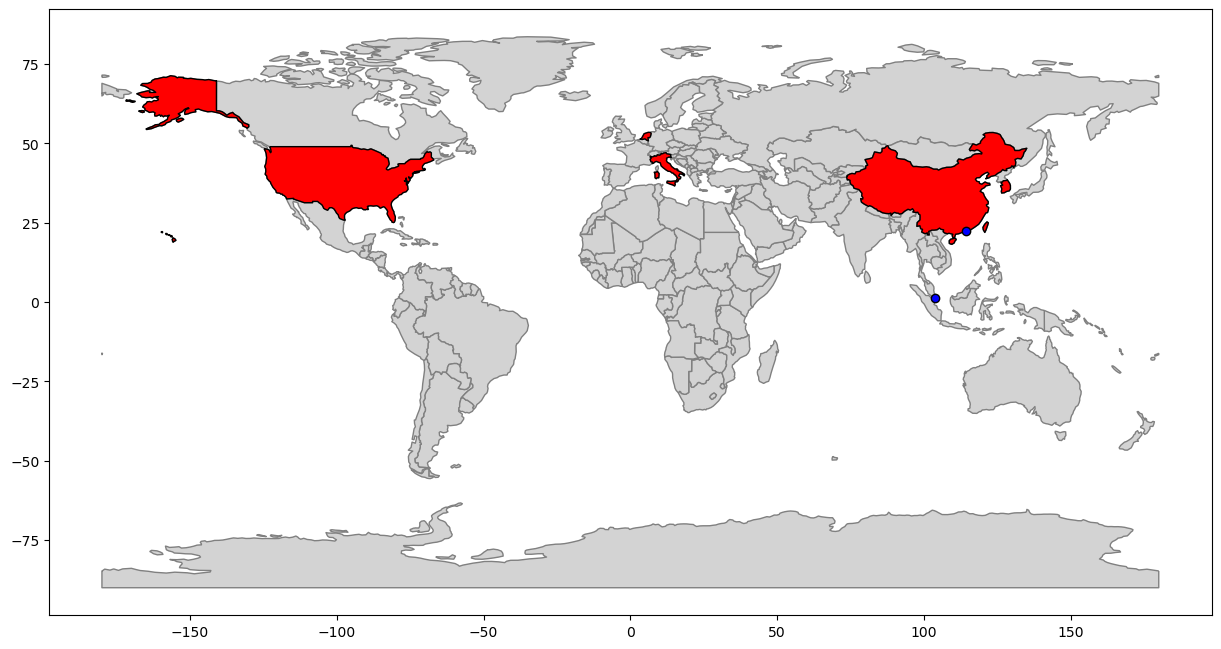

In [16]:
#| label: fig-mapa
#| fig-cap: Mapa con los lugares del que proceden las IPs
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

singapur = ciudades[ciudades['name'] == 'Singapore']
hongkong = ciudades[ciudades['name'] == 'Hong Kong']

singapur.plot(ax=ax, edgecolor='black', color='blue')
hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

In [17]:
import plotly.express as px

In [18]:
import seaborn as sns

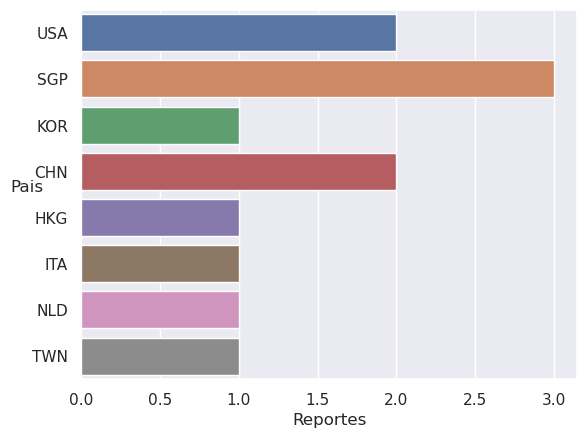

In [19]:
#| label: fig-countplot
#| fig-cap: Pais vs Nro de reportes
sns.set(style='darkgrid')
sns.countplot(data=dfgdp, y="codigoPais")
ylabel = plt.ylabel("Pais", rotation='horizontal')
plt.xlabel("Reportes")
plt.show()

In [20]:
recuento = dfgdp["codigoPais"].value_counts().to_dict()

dfPlot = pd.DataFrame(data={"codigoPais": list(recuento.keys()), "Reportes": list(recuento.values())})
dfPlot

fig = px.scatter_geo(dfPlot, locations="codigoPais", color="codigoPais", size="Reportes",
                     projection="equirectangular")
fig.write_image("data/plotly.png")

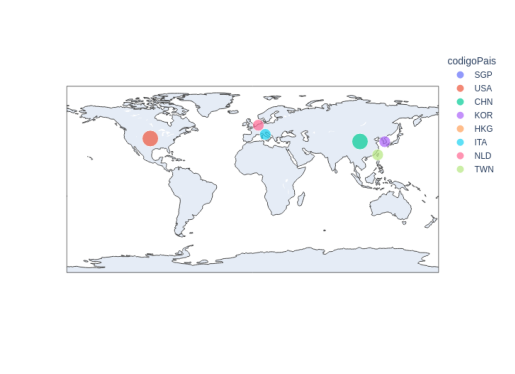

In [21]:
#| label: fig-scatergeo
#| fig-cap: Scatterplot con tamaño en función de número de reportes
from PIL import Image 

image = np.asarray(Image.open('data/plotly.png'))
plt.imshow(image)
plt.grid(False)
plt.axis(False)
plt.show()

In [22]:
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Singapore,3
1,United States,2
2,China,2
3,"Korea, Republic of",1
4,Hong Kong,1
5,Italy,1
6,Netherlands,1
7,"Taiwan, Province of China",1


## Análisis de frecuencia
Para así poder de tratar de identificar cierto patron asociado a la hora de ataque. 

### Extracción de información

In [23]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

patron = "[a-z]{3}\/[0-9]{2}\/[0-9]{4}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

patron = "[0-9]{2}\:[0-9]{2}\:[0-9]{2}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

In [24]:
with open("data/IPsSSH.txt") as ips:
    data = ips.read()
    data = data.replace("\n", " ").split()

In [25]:
for i in range(int(len(data)/3)):
    data[i] = data[i] + " " + data[int(len(data)/3)+i] + " " + data[(int(len(data)/3))*2+i]

In [26]:
data = data[:int(len(data)/3)]

In [27]:
for i in data:
    print(i)

54.144.244.57 may/23/2023 01:55:10
188.166.216.223 may/23/2023 02:05:53
220.94.228.162 may/23/2023 03:36:25
218.92.0.99 may/23/2023 04:12:35
116.193.159.2 may/23/2023 04:20:54
109.117.92.13 may/23/2023 04:38:43
167.99.112.43 may/23/2023 04:42:51
89.248.163.219 may/23/2023 05:34:31
143.198.204.177 may/23/2023 06:51:28
61.177.173.45 may/23/2023 09:07:17
8.222.204.225 may/23/2023 09:49:45
220.135.119.188 may/23/2023 09:54:14


In [28]:
from datetime import datetime, time

In [34]:
diccInfo = {
    "IP": [],
    "Fecha": [],
    "Hora": []
}
eventos = []

for i in data:
    diccInfo["IP"].append(i.split()[0])
    diccInfo["Fecha"].append(i.split()[1])
    mes = 5
    dia = int(i.split()[1].split(sep="/")[1])
    año = int(i.split()[1].split(sep="/")[2])
    h = int(i.split()[2].split(sep=":")[0])
    m = int(i.split()[2].split(sep=":")[1])
    s = int(i.split()[2].split(sep=":")[2])
    diccInfo["Hora"].append(time(hour=int(h), minute=int(m), second=int(s)))
    #diccInfo["Hora"].append(i.split()[2])
    
    eventos.append((i.split()[0],datetime(year=año, month=mes, day=dia, hour=h, minute=m)))

In [35]:
dfHora = pd.DataFrame(data=diccInfo)
dfHora

,IP,Fecha,Hora
0,54.144.244.57,may/23/2023,01:55:10
1,188.166.216.223,may/23/2023,02:05:53
2,220.94.228.162,may/23/2023,03:36:25
3,218.92.0.99,may/23/2023,04:12:35
4,116.193.159.2,may/23/2023,04:20:54
5,109.117.92.13,may/23/2023,04:38:43
6,167.99.112.43,may/23/2023,04:42:51
7,89.248.163.219,may/23/2023,05:34:31
8,143.198.204.177,may/23/2023,06:51:28
9,61.177.173.45,may/23/2023,09:07:17


In [36]:
dfHora["Pais"] = None
for index, row in dfHora.iterrows():
    ip = row["IP"]
    row["Pais"] = df[df['ip'] == ip].iloc[0]['pais']

In [37]:
dfHora

,IP,Fecha,Hora,Pais
0,54.144.244.57,may/23/2023,01:55:10,United States
1,188.166.216.223,may/23/2023,02:05:53,Singapore
2,220.94.228.162,may/23/2023,03:36:25,"Korea, Republic of"
3,218.92.0.99,may/23/2023,04:12:35,China
4,116.193.159.2,may/23/2023,04:20:54,Hong Kong
5,109.117.92.13,may/23/2023,04:38:43,Italy
6,167.99.112.43,may/23/2023,04:42:51,United States
7,89.248.163.219,may/23/2023,05:34:31,Netherlands
8,143.198.204.177,may/23/2023,06:51:28,Singapore
9,61.177.173.45,may/23/2023,09:07:17,China


In [38]:
for evento in eventos:
    print(evento[1])

2023-05-23 01:55:00
2023-05-23 02:05:00
2023-05-23 03:36:00
2023-05-23 04:12:00
2023-05-23 04:20:00
2023-05-23 04:38:00
2023-05-23 04:42:00
2023-05-23 05:34:00
2023-05-23 06:51:00
2023-05-23 09:07:00
2023-05-23 09:49:00
2023-05-23 09:54:00


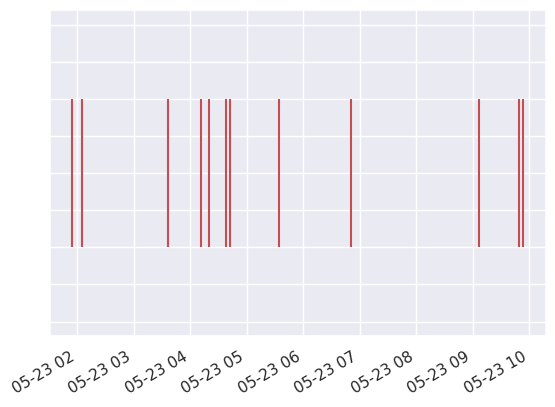

In [39]:
#| warning: false
#| label: fig-eventos
#| fig-cap: Visualización de eventos de SSH
fig, ax = plt.subplots()

fecha = [evento[1] for evento in eventos]
etiquetas = [evento[0] for evento in eventos]
ax.eventplot(fecha, lineoffsets=0.1, linelengths=0.1, color='r')
ax.set_ylabel(None)
ax.set_yticklabels([])
fig.autofmt_xdate()


## Análisis de ISPs

In [44]:
recuento = df["isp"].value_counts().to_dict()

recuento = pd.DataFrame(data={"ISP": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,ISP,Reportes
0,DigitalOcean LLC,3
1,ChinaNet Jiangsu Province Network,2
2,Amazon Data Services NoVa,1
3,KT Corporation,1
4,Pacswitch Globe Telecom Limited,1
5,Vodafone Italia S.p.A.,1
6,FiberXpress BV,1
7,Alibaba.com Singapore E-Commerce Private Limited,1
8,Chunghwa Telecom Co. Ltd.,1


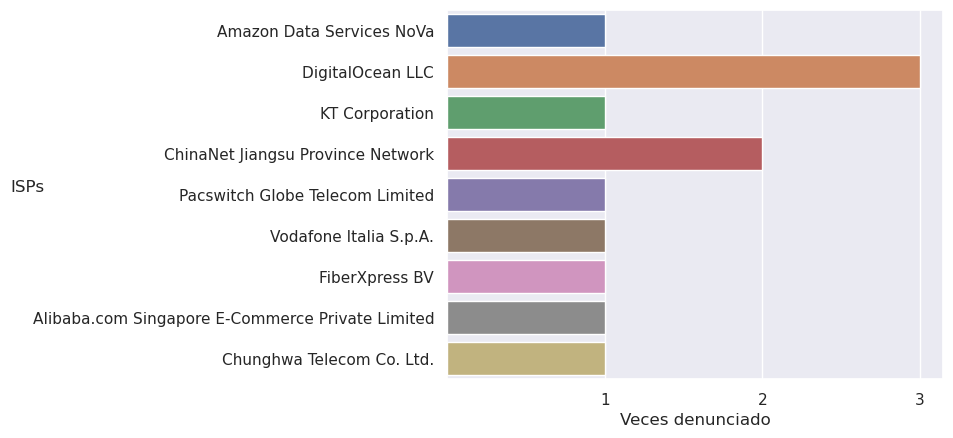

In [66]:
#| label: fig-isps
#| fig-cap: Número de veces que se denuncio un ISp
fig=plt.plot(figsize=(15, 10))
sns.countplot(data=df, y="isp")
plt.tick_params(labelsize = 11)
plt.xticks([1,2,3])
plt.ylabel("ISPs", rotation=0)
plt.xlabel("Veces denunciado")
plt.show()
